In [50]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
import os

In [51]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [52]:
def batch_elastic_transform(images, sigma, alpha, height, width, random_state=None):
    """
    Elastic deformation of images as described in [Simard 2003].

    Args:
        images: a two-dimensional numpy array; list of flattened images
        sigma: variance of the gaussian kernel
        alpha: multiplier for the displacement fields
        height: image height
        width: image width
        random_state: numpy random state object

    Returns:
        elastically distorted images of the same shape
    """
    assert len(images.shape) == 2
    e_images = np.empty_like(images)
    e_images[:] = images

    e_images = e_images.reshape(-1, height, width)

    if random_state is None:
        random_state = np.random.RandomState(None)
    x, y = np.mgrid[0:height, 0:width]

    for i in range(e_images.shape[0]):
        dx = gaussian_filter((random_state.rand(height, width) * 2 - 1),
                           sigma, mode='constant') * alpha
        dy = gaussian_filter((random_state.rand(height, width) * 2 - 1),
                           sigma, mode='constant') * alpha
        indices = x + dx, y + dy
        e_images[i] = map_coordinates(e_images[i], indices, order=1)

    return e_images.reshape(-1, height*width)

In [53]:
random_state = np.random.RandomState(None)
dx1 = random_state.rand(28, 28) * 2 - 1
dy1 = random_state.rand(28, 28) * 2 - 1
dx2 = gaussian_filter(dx1, 4, mode='constant')
dy2 = gaussian_filter(dy1, 4, mode='constant')

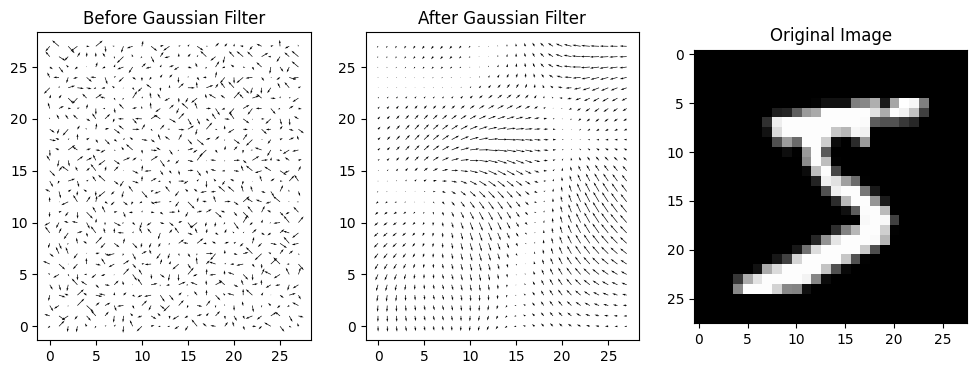

In [54]:
x, y = np.mgrid[0:28, 0:28]

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.quiver(x, y, dx1, dy1)
plt.title('Before Gaussian Filter')
plt.subplot(132)
plt.quiver(x, y, dx2, dy2)
plt.title('After Gaussian Filter')
# Demonstrate elastic transform on MNIST image
img = x_train[0]
plt.subplot(133)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.show()

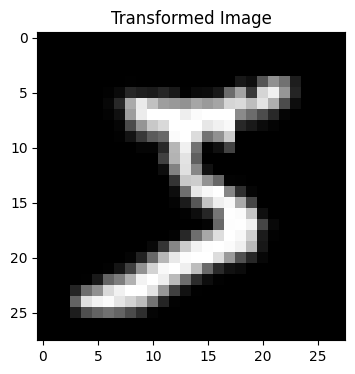

In [55]:
transformed_img = batch_elastic_transform(
    img.reshape(1, -1),
    sigma=4,
    alpha=20,
    height=28,
    width=28
)

plt.figure(figsize=(4, 4))
plt.imshow(transformed_img.reshape(28, 28), cmap='gray')
plt.title('Transformed Image')
plt.show()

In [56]:
def transform_dataset(x_train, batch_size=1000, sigma=4, alpha=20):
    """
    Transform entire dataset in batches to avoid memory issues
    """
    height, width = x_train.shape[1:]
    n_samples = x_train.shape[0]

    # Initialize array for transformed images
    transformed_images = np.zeros((n_samples, height * width))

    # Process in batches
    for i in tqdm(range(0, n_samples, batch_size)):
        batch_end = min(i + batch_size, n_samples)
        batch = x_train[i:batch_end]

        # Reshape batch to 2D array (n_samples, pixels)
        batch_flat = batch.reshape(batch_end - i, -1)

        # Apply transformation
        transformed = batch_elastic_transform(
            batch_flat,
            sigma=sigma,
            alpha=alpha,
            height=height,
            width=width
        )

        transformed_images[i:batch_end] = transformed

    return transformed_images

In [57]:
transformed_train = transform_dataset(x_train)

100%|███████████████████████████████████████████| 60/60 [00:05<00:00, 10.23it/s]


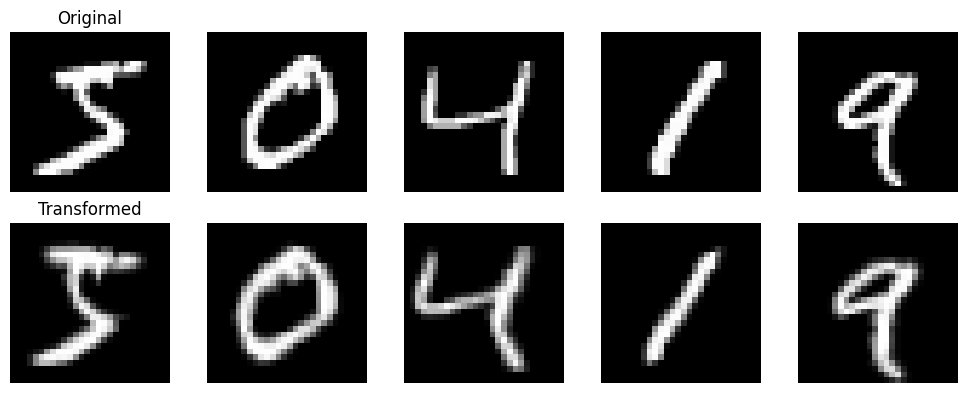

In [58]:
def plot_comparison(original, transformed, num_images=5):
    plt.figure(figsize=(2*num_images, 4))

    for i in range(num_images):
        # Original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original[i], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Original')

        # Transformed image
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(transformed[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Transformed')

    plt.tight_layout()
    plt.show()

# Plot some examples
plot_comparison(x_train, transformed_train)

In [59]:
def list_of_norms(X):
    """
    Computes squared L2 norm for each vector in X.

    Args:
        X: tensor of shape [n, d] containing n d-dimensional vectors

    Returns:
        tensor of shape [n] containing squared L2 norms
    """
    return tf.reduce_sum(tf.pow(X, 2), axis=1)

In [60]:
def list_of_distances(X, Y):
    """
    Computes pairwise squared Euclidean distances between two sets of vectors.

    Args:
        X: tensor of shape [n, d] containing n d-dimensional vectors
        Y: tensor of shape [m, d] containing m d-dimensional vectors

    Returns:
        tensor of shape [n, m] containing all pairwise distances
    """
    XX = tf.reshape(list_of_norms(X), shape=(-1, 1))
    YY = tf.reshape(list_of_norms(Y), shape=(1, -1))
    output = XX + YY - 2 * tf.matmul(X, tf.transpose(Y))

    return output

In [61]:
class PrototypeAutoencoder(tf.keras.Model):
    def __init__(self, input_shape, n_classes, n_prototypes=15):
        super(PrototypeAutoencoder, self).__init__()
        # Network parameters
        self.n_prototypes = n_prototypes
        self.input_shape = input_shape
        self.n_classes = n_classes

        # Encoder layers
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=input_shape),
            tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(10, 3, strides=1, padding='same', activation='sigmoid'),
            tf.keras.layers.Flatten()
        ])

        # Decoder layers
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(shape=(160,)),
            tf.keras.layers.Dense(4*4*10),
            tf.keras.layers.Reshape((4, 4, 10)),
            tf.keras.layers.Conv2DTranspose(32, 3, strides=1, padding='valid', activation='relu'),  # 4x4x32
            tf.keras.layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu'),  # 8x8x32
            tf.keras.layers.Conv2DTranspose(32, 3, strides=1, padding='valid', activation='relu'),  # 14x14x32
            tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding='same', activation='sigmoid') # 28x28x1
        ])

        # Prototype vectors
        self.prototype_vectors = tf.Variable(
            tf.random.uniform(shape=[n_prototypes, 4*4*10], dtype=tf.float32),
            name='prototype_vectors'
        )

        # Classification layer
        self.classifier = tf.keras.layers.Dense(n_classes)

        print(self.encoder.summary())
        print(self.decoder.summary())


    def call(self, inputs):
        # Ensure input shape is correct
        if len(inputs.shape) == 2:
            inputs = tf.reshape(inputs, [-1, 28, 28, 1])

        # Encode
        features = self.encoder(inputs)

        # Calculate distances to prototypes
        prototype_distances = list_of_distances(features, self.prototype_vectors)

        # Get logits
        logits = self.classifier(prototype_distances)

        # Decode
        decoded = self.decoder(features)

        return logits, decoded, features, prototype_distances

In [62]:
def train_step(model, optimizer, x, y, lambda_params):
    with tf.GradientTape() as tape:
        # Forward pass
        x = tf.reshape(x, [-1, 28, 28, 1])
        logits, decoded, features, prototype_distances = model(x)

        # Calculate losses
        classification_loss = tf.reduce_mean(
            tf.keras.losses.categorical_crossentropy(y, logits, from_logits=True)
        )
        x_flat = tf.reshape(x, [-1, 784])
        decoded_flat = tf.reshape(decoded, [-1, 784])

        reconstruction_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(x_flat, decoded_flat)
        )

        # Prototype losses
        feature_distances = list_of_distances(model.prototype_vectors, features)
        error_1 = tf.reduce_mean(tf.reduce_min(feature_distances, axis=1))
        error_2 = tf.reduce_mean(tf.reduce_min(prototype_distances, axis=1))

        # Total loss
        total_loss = (lambda_params['class'] * classification_loss +
                     lambda_params['ae'] * reconstruction_loss +
                     lambda_params['1'] * error_1 +
                     lambda_params['2'] * error_2)

    # Backpropagation
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Return losses as a dictionary
    return {
        'classification': classification_loss,
        'reconstruction': reconstruction_loss,
        'error_1': error_1,
        'error_2': error_2,
        'total': total_loss
    }

In [63]:
def visualize_reconstructions(model, dataset):
    # Get multiple batches of images and select diverse samples
    sample_images = []
    for x_batch, _ in dataset.take(5):
        # Select 2 random images from each batch
        indices = tf.random.shuffle(tf.range(x_batch.shape[0]))[:2]
        sample_images.extend(tf.gather(x_batch, indices))
        if len(sample_images) >= 10:
            break

    sample_images = tf.stack(sample_images[:10])
    sample_images = tf.reshape(sample_images, [-1, 28, 28, 1])  # Ensure 4D shape

    # Reconstruct images
    _, reconstructed, _, _ = model(sample_images)

    # Plot results
    fig, axes = plt.subplots(2, 10, figsize=(20, 4))
    plt.suptitle('Original Images (top) vs Reconstructed Images (bottom)', y=1.05)

    for i in range(10):
        # Ensure proper shape for visualization
        orig_img = tf.squeeze(sample_images[i]).numpy()
        recon_img = tf.squeeze(reconstructed[i]).numpy()

        axes[0, i].imshow(orig_img, cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(recon_img, cmap='gray')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

In [65]:
def train_model(model, train_dataset, valid_dataset, test_dataset, epochs=150,
                learning_rate=0.0001, batch_size=250, log_dir="logs"):

    optimizer = tf.keras.optimizers.Adam(learning_rate)
    lambda_params = {'class': 15, 'ae': 1, '1': 10, '2': 5}

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Training loop
        for x_batch, y_batch in train_dataset:
            # Apply elastic transform
            x_batch = tf.reshape(x_batch, [-1, 28, 28, 1])
            x_flat = tf.reshape(x_batch, [-1, 784])
            x_batch_elastic = batch_elastic_transform(x_flat, sigma=4, alpha=20,
                                                      height=28, width=28)
            losses = train_step(model, optimizer, x_batch_elastic, y_batch, lambda_params)

        # Validation
        val_accuracy = tf.keras.metrics.CategoricalAccuracy()
        for x_val, y_val in valid_dataset:
            logits, _, _, _ = model(x_val)
            val_accuracy.update_state(y_val, logits)

        # Print results for the epoch
        losses_cleaned = {key: float(value.numpy()) for key, value in losses.items()}
        print(f"Validation accuracy: {val_accuracy.result().numpy():.4f}, Loss: {losses_cleaned}\n")
        
        # Generate and print prototypes every 50 epochs
        # if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
        #     # Decode prototype vectors to image space
        #     prototypes = model.prototype_vectors.numpy()

        #     # Use the decoder with prototype vectors reshaped to match encoder output
        #     decoded_prototypes = model.decoder(prototypes.reshape(-1, 4, 4, 10)).numpy()

        #     # Reshape to 28x28 images
        #     decoded_prototypes = decoded_prototypes.reshape(-1, 28, 28)

        #     # Plot decoded prototypes
        #     plt.figure(figsize=(15, 6))
        #     for i in range(len(decoded_prototypes)):
        #         plt.subplot(2, 8, i + 1)
        #         plt.imshow(decoded_prototypes[i], cmap='gray')
        #         plt.title(f'Prototype {i}')
        #         plt.axis('off')
        #     plt.tight_layout()
        #     plt.suptitle(f'Final Learned Prototypes at Epoch {epoch+1}', y=1.02)
        #     plt.show()

In [66]:
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [67]:
# Create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(250)
valid_dataset = tf.data.Dataset.from_tensor_slices((x_test[:5000], y_test[:5000])).batch(250)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test[5000:], y_test[5000:])).batch(250)

In [68]:
# Create and train model
model = PrototypeAutoencoder(input_shape=(28, 28, 1), n_classes=10, n_prototypes=15)

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 4, 4, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 4, 4, 10)       │         2,890 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 160)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,706 (84.79 KB)

 Trainable params: 21,706 (84.79 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 160)            │        25,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 4, 4, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_24             │ (None, 6, 6, 32)       │         2,912 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_25             │ (None, 12, 12, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_26             │ (None, 14, 14, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_27             │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,457 (185.38 KB)

 Trainable params: 47,457 (185.38 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
train_model(model, train_dataset, valid_dataset, test_dataset)

Epoch 1/150


2024-12-11 14:20:19.333558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:20:19.637350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.1164, Loss: {'classification': 5.963315486907959, 'reconstruction': 0.3658057451248169, 'error_1': 12.808551788330078, 'error_2': 9.042642593383789, 'total': 263.1142578125}

Epoch 2/150


2024-12-11 14:20:50.238696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:20:50.525925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.4278, Loss: {'classification': 3.45352840423584, 'reconstruction': 0.2822161912918091, 'error_1': 12.1531982421875, 'error_2': 6.953816890716553, 'total': 208.38621520996094}

Epoch 3/150


2024-12-11 14:21:20.184486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:21:20.464894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.5564, Loss: {'classification': 1.7703783512115479, 'reconstruction': 0.269151508808136, 'error_1': 11.696179389953613, 'error_2': 6.223525524139404, 'total': 174.9042510986328}

Epoch 4/150


2024-12-11 14:21:50.353953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:21:50.625911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.6896, Loss: {'classification': 1.2357168197631836, 'reconstruction': 0.25653332471847534, 'error_1': 11.31375503540039, 'error_2': 5.057051181793213, 'total': 157.215087890625}

Epoch 5/150


2024-12-11 14:22:19.973980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:22:20.238318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7278, Loss: {'classification': 1.1240683794021606, 'reconstruction': 0.2368125319480896, 'error_1': 11.069145202636719, 'error_2': 4.655911922454834, 'total': 151.06884765625}

Epoch 6/150


2024-12-11 14:22:49.721889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:22:50.001945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7450, Loss: {'classification': 1.079593539237976, 'reconstruction': 0.22229014337062836, 'error_1': 10.68117904663086, 'error_2': 4.646856307983398, 'total': 146.46226501464844}

Epoch 7/150


2024-12-11 14:23:19.935285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:23:20.215673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7576, Loss: {'classification': 0.9967716932296753, 'reconstruction': 0.20531700551509857, 'error_1': 10.674310684204102, 'error_2': 4.577240467071533, 'total': 144.78619384765625}

Epoch 8/150


2024-12-11 14:23:49.446410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:23:49.717153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7704, Loss: {'classification': 0.9115968346595764, 'reconstruction': 0.1949586570262909, 'error_1': 10.021732330322266, 'error_2': 4.461747169494629, 'total': 136.3949737548828}

Epoch 9/150


2024-12-11 14:24:19.632807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:24:19.895306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7772, Loss: {'classification': 0.8809758424758911, 'reconstruction': 0.1874539703130722, 'error_1': 10.169059753417969, 'error_2': 4.42168664932251, 'total': 137.2011260986328}

Epoch 10/150


2024-12-11 14:24:49.777401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:24:50.022521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7822, Loss: {'classification': 0.8920741677284241, 'reconstruction': 0.1812899261713028, 'error_1': 9.80050277709961, 'error_2': 4.386724472045898, 'total': 133.5010528564453}

Epoch 11/150


2024-12-11 14:25:20.958396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:25:21.212726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7902, Loss: {'classification': 0.8165814280509949, 'reconstruction': 0.17797863483428955, 'error_1': 9.912193298339844, 'error_2': 4.3024091720581055, 'total': 133.0606689453125}

Epoch 12/150


2024-12-11 14:25:54.866212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:25:55.120444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7932, Loss: {'classification': 0.7571743726730347, 'reconstruction': 0.17523297667503357, 'error_1': 9.327939987182617, 'error_2': 4.231067180633545, 'total': 125.96759033203125}

Epoch 13/150


2024-12-11 14:26:29.399730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:26:29.691884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7998, Loss: {'classification': 0.7719882130622864, 'reconstruction': 0.17358393967151642, 'error_1': 10.003839492797852, 'error_2': 4.217595100402832, 'total': 132.87977600097656}

Epoch 14/150


2024-12-11 14:27:03.320007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:27:03.592788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8074, Loss: {'classification': 0.7637726068496704, 'reconstruction': 0.17066949605941772, 'error_1': 9.343232154846191, 'error_2': 4.109574317932129, 'total': 125.60745239257812}

Epoch 15/150


2024-12-11 14:27:36.191355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:27:36.451457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8140, Loss: {'classification': 0.7706137895584106, 'reconstruction': 0.1698967069387436, 'error_1': 9.992955207824707, 'error_2': 4.131346702575684, 'total': 132.3153839111328}

Epoch 16/150


2024-12-11 14:28:09.543925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:28:09.816150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8198, Loss: {'classification': 0.728240430355072, 'reconstruction': 0.16665907204151154, 'error_1': 9.398558616638184, 'error_2': 4.190978527069092, 'total': 126.03074645996094}

Epoch 17/150


2024-12-11 14:28:40.124237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:28:40.373234: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8198, Loss: {'classification': 0.699493944644928, 'reconstruction': 0.1647971272468567, 'error_1': 8.885002136230469, 'error_2': 4.224666118621826, 'total': 120.63055419921875}

Epoch 18/150


2024-12-11 14:29:11.729374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:29:12.036958: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8230, Loss: {'classification': 0.7028446197509766, 'reconstruction': 0.16510984301567078, 'error_1': 9.09009838104248, 'error_2': 4.096807956695557, 'total': 122.09280395507812}

Epoch 19/150


2024-12-11 14:29:43.699950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:29:44.030835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8258, Loss: {'classification': 0.7457095980644226, 'reconstruction': 0.1621999889612198, 'error_1': 9.390974044799805, 'error_2': 4.151811599731445, 'total': 126.01664733886719}

Epoch 20/150


2024-12-11 14:30:14.600858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:30:14.871263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8260, Loss: {'classification': 0.6630338430404663, 'reconstruction': 0.16273829340934753, 'error_1': 9.10257625579834, 'error_2': 4.131387233734131, 'total': 121.79094696044922}

Epoch 21/150


2024-12-11 14:30:47.167290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:30:47.475561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8314, Loss: {'classification': 0.6829772591590881, 'reconstruction': 0.16184717416763306, 'error_1': 9.625059127807617, 'error_2': 4.140542984008789, 'total': 127.35981750488281}

Epoch 22/150


2024-12-11 14:31:19.520794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:31:19.824049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8330, Loss: {'classification': 0.6399509310722351, 'reconstruction': 0.16154992580413818, 'error_1': 8.786479949951172, 'error_2': 4.1591315269470215, 'total': 118.4212646484375}

Epoch 23/150


2024-12-11 14:31:49.887761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:31:50.182037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8348, Loss: {'classification': 0.6718230843544006, 'reconstruction': 0.16045936942100525, 'error_1': 8.546751022338867, 'error_2': 4.110377311706543, 'total': 116.25720977783203}

Epoch 24/150


2024-12-11 14:32:20.400556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:32:20.677809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8384, Loss: {'classification': 0.6451460123062134, 'reconstruction': 0.15938277542591095, 'error_1': 8.204431533813477, 'error_2': 4.0767717361450195, 'total': 112.26473999023438}

Epoch 25/150


2024-12-11 14:32:50.851141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:32:51.150150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8414, Loss: {'classification': 0.6345680356025696, 'reconstruction': 0.15780824422836304, 'error_1': 9.45432186126709, 'error_2': 4.095010280609131, 'total': 124.6946029663086}

Epoch 26/150


2024-12-11 14:33:21.244463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:33:21.531813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8416, Loss: {'classification': 0.5890791416168213, 'reconstruction': 0.15851056575775146, 'error_1': 8.347871780395508, 'error_2': 4.117912292480469, 'total': 113.06297302246094}

Epoch 27/150


2024-12-11 14:33:52.046350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:33:52.314988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8432, Loss: {'classification': 0.6339943408966064, 'reconstruction': 0.15644186735153198, 'error_1': 8.561078071594238, 'error_2': 4.073361396789551, 'total': 115.6439437866211}

Epoch 28/150


2024-12-11 14:34:23.322197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:34:23.602309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8450, Loss: {'classification': 0.6218205690383911, 'reconstruction': 0.15659697353839874, 'error_1': 9.149616241455078, 'error_2': 4.04091739654541, 'total': 121.18466186523438}

Epoch 29/150


2024-12-11 14:34:52.908440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:34:53.172446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8444, Loss: {'classification': 0.6964357495307922, 'reconstruction': 0.1589512825012207, 'error_1': 8.240703582763672, 'error_2': 4.014798641204834, 'total': 113.08651733398438}

Epoch 30/150


2024-12-11 14:35:23.139612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:35:23.454616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8476, Loss: {'classification': 0.625664472579956, 'reconstruction': 0.15720386803150177, 'error_1': 7.984541893005371, 'error_2': 3.956160068511963, 'total': 109.16838836669922}

Epoch 31/150


2024-12-11 14:35:53.172057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:35:53.439184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8508, Loss: {'classification': 0.6212140321731567, 'reconstruction': 0.15514825284481049, 'error_1': 8.833173751831055, 'error_2': 3.9573404788970947, 'total': 117.59180450439453}

Epoch 32/150


2024-12-11 14:36:23.311080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:36:23.593093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8540, Loss: {'classification': 0.593453049659729, 'reconstruction': 0.15429644286632538, 'error_1': 8.436853408813477, 'error_2': 4.070258140563965, 'total': 113.77590942382812}

Epoch 33/150


2024-12-11 14:36:52.866509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:36:53.145268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8504, Loss: {'classification': 0.6517122983932495, 'reconstruction': 0.15730005502700806, 'error_1': 8.486959457397461, 'error_2': 3.8609161376953125, 'total': 114.10716247558594}

Epoch 34/150


2024-12-11 14:37:22.851465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:37:23.120725: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8568, Loss: {'classification': 0.571631133556366, 'reconstruction': 0.15534751117229462, 'error_1': 8.608213424682617, 'error_2': 4.063133239746094, 'total': 115.12761688232422}

Epoch 35/150


2024-12-11 14:37:52.841373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:37:53.123396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8572, Loss: {'classification': 0.5286753177642822, 'reconstruction': 0.15509457886219025, 'error_1': 9.113245010375977, 'error_2': 3.971844434738159, 'total': 119.07688903808594}

Epoch 36/150


2024-12-11 14:38:22.908523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:38:23.181268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8562, Loss: {'classification': 0.6224485635757446, 'reconstruction': 0.15557736158370972, 'error_1': 8.73198127746582, 'error_2': 3.9263341426849365, 'total': 116.44378662109375}

Epoch 37/150


2024-12-11 14:38:52.898894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:38:53.178201: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8618, Loss: {'classification': 0.5689876079559326, 'reconstruction': 0.1549840271472931, 'error_1': 8.750303268432617, 'error_2': 4.062489032745361, 'total': 116.50527954101562}

Epoch 38/150


2024-12-11 14:39:22.958821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:39:23.229435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8604, Loss: {'classification': 0.6294512152671814, 'reconstruction': 0.15576381981372833, 'error_1': 8.83720588684082, 'error_2': 4.053608417510986, 'total': 118.23763275146484}

Epoch 39/150


2024-12-11 14:39:52.561107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:39:52.831101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8632, Loss: {'classification': 0.6146737337112427, 'reconstruction': 0.15291331708431244, 'error_1': 8.466870307922363, 'error_2': 3.9174044132232666, 'total': 113.62873840332031}

Epoch 40/150


2024-12-11 14:40:23.327001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:40:23.626428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8610, Loss: {'classification': 0.5524532198905945, 'reconstruction': 0.15569177269935608, 'error_1': 8.498723983764648, 'error_2': 3.9305155277252197, 'total': 113.08231353759766}

Epoch 41/150


2024-12-11 14:40:53.488618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:40:53.844421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8636, Loss: {'classification': 0.5011534094810486, 'reconstruction': 0.15264087915420532, 'error_1': 8.37269115447998, 'error_2': 3.8517463207244873, 'total': 110.65559387207031}

Epoch 42/150


2024-12-11 14:41:25.095288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:41:25.404342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8654, Loss: {'classification': 0.5616827607154846, 'reconstruction': 0.1556619554758072, 'error_1': 8.39419174194336, 'error_2': 3.7965426445007324, 'total': 111.50553131103516}

Epoch 43/150


2024-12-11 14:41:56.272994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:41:56.585262: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8668, Loss: {'classification': 0.5807161331176758, 'reconstruction': 0.15418611466884613, 'error_1': 8.388226509094238, 'error_2': 3.816497564315796, 'total': 111.82968139648438}

Epoch 44/150


2024-12-11 14:42:28.234433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:42:28.547347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8686, Loss: {'classification': 0.5601806640625, 'reconstruction': 0.15483707189559937, 'error_1': 8.663445472717285, 'error_2': 3.8897316455841064, 'total': 114.64065551757812}

Epoch 45/150


2024-12-11 14:42:59.568486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:42:59.857265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8678, Loss: {'classification': 0.5701085925102234, 'reconstruction': 0.15297150611877441, 'error_1': 8.042698860168457, 'error_2': 3.833116292953491, 'total': 108.29716491699219}

Epoch 46/150


2024-12-11 14:43:30.405386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:43:30.686870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8658, Loss: {'classification': 0.5126846432685852, 'reconstruction': 0.15509311854839325, 'error_1': 7.902670383453369, 'error_2': 4.000694751739502, 'total': 106.87553405761719}

Epoch 47/150


2024-12-11 14:44:04.869539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:44:05.177540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8684, Loss: {'classification': 0.5038756728172302, 'reconstruction': 0.15328361093997955, 'error_1': 7.726287841796875, 'error_2': 3.765798568725586, 'total': 103.80329132080078}

Epoch 48/150


2024-12-11 14:44:36.078548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:44:36.359764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8698, Loss: {'classification': 0.47949472069740295, 'reconstruction': 0.1537923663854599, 'error_1': 7.750202655792236, 'error_2': 3.9141480922698975, 'total': 104.41898345947266}

Epoch 49/150


2024-12-11 14:45:07.796586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:45:08.149617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8704, Loss: {'classification': 0.5398881435394287, 'reconstruction': 0.15272608399391174, 'error_1': 7.8062591552734375, 'error_2': 3.907768726348877, 'total': 105.85247802734375}

Epoch 50/150


2024-12-11 14:45:37.890391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:45:38.173345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8730, Loss: {'classification': 0.5427629947662354, 'reconstruction': 0.15388089418411255, 'error_1': 8.61300277709961, 'error_2': 3.884695529937744, 'total': 113.84883117675781}

Epoch 51/150


2024-12-11 14:46:08.990680: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:46:09.322567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8708, Loss: {'classification': 0.5405691862106323, 'reconstruction': 0.1532461941242218, 'error_1': 7.707319736480713, 'error_2': 3.804995536804199, 'total': 104.35995483398438}

Epoch 52/150


2024-12-11 14:46:38.559459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:46:38.834123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8692, Loss: {'classification': 0.5461620092391968, 'reconstruction': 0.15270355343818665, 'error_1': 7.369530200958252, 'error_2': 3.8676862716674805, 'total': 101.37886810302734}

Epoch 53/150


In [34]:
# train_model(model, train_dataset, valid_dataset, test_dataset)

Epoch 1/150


2024-12-10 01:24:26.361076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:24:26.648805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.1866, Loss: {'classification': 2.9525434970855713, 'reconstruction': 0.3685961961746216, 'error_1': 12.499838829040527, 'error_2': 8.095377922058105, 'total': 195.36932373046875}

Epoch 2/150


2024-12-10 01:24:56.352325: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:24:56.617972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.4406, Loss: {'classification': 1.7538641691207886, 'reconstruction': 0.2829200029373169, 'error_1': 11.95059585571289, 'error_2': 5.911922454833984, 'total': 166.8871307373047}

Epoch 3/150


2024-12-10 01:25:28.021660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:25:28.397273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.4980, Loss: {'classification': 1.5494422912597656, 'reconstruction': 0.26440995931625366, 'error_1': 11.761688232421875, 'error_2': 4.794623374938965, 'total': 157.3488311767578}

Epoch 4/150


2024-12-10 01:25:59.394045: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:25:59.681551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.5328, Loss: {'classification': 1.405198574066162, 'reconstruction': 0.25454938411712646, 'error_1': 11.530878067016602, 'error_2': 4.333420753479004, 'total': 151.28240966796875}

Epoch 5/150


2024-12-10 01:26:30.164363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:26:30.449449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.5556, Loss: {'classification': 1.3747068643569946, 'reconstruction': 0.24200104176998138, 'error_1': 11.359678268432617, 'error_2': 4.100034236907959, 'total': 148.08602905273438}

Epoch 6/150


2024-12-10 01:27:00.732922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:27:01.018393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.5784, Loss: {'classification': 1.349079966545105, 'reconstruction': 0.2207639217376709, 'error_1': 11.133548736572266, 'error_2': 4.007681846618652, 'total': 145.08546447753906}

Epoch 7/150


2024-12-10 01:27:31.381225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:27:31.656705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.5888, Loss: {'classification': 1.2825833559036255, 'reconstruction': 0.20549997687339783, 'error_1': 11.292192459106445, 'error_2': 3.823500633239746, 'total': 145.0707550048828}

Epoch 8/150


2024-12-10 01:28:01.918855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:28:02.197942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.6000, Loss: {'classification': 1.2511104345321655, 'reconstruction': 0.19457627832889557, 'error_1': 10.883845329284668, 'error_2': 3.8417091369628906, 'total': 140.752685546875}

Epoch 9/150


2024-12-10 01:28:32.614818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:28:32.888203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.6114, Loss: {'classification': 1.2308405637741089, 'reconstruction': 0.186951145529747, 'error_1': 10.520675659179688, 'error_2': 3.8275632858276367, 'total': 136.83993530273438}

Epoch 10/150


2024-12-10 01:29:03.525485: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:29:03.796416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.6218, Loss: {'classification': 1.144436001777649, 'reconstruction': 0.1807125359773636, 'error_1': 10.776103019714355, 'error_2': 3.836254596710205, 'total': 138.5673828125}

Epoch 11/150


2024-12-10 01:29:33.853890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:29:34.129426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.6346, Loss: {'classification': 1.1641775369644165, 'reconstruction': 0.1778222769498825, 'error_1': 10.655457496643066, 'error_2': 3.7998645305633545, 'total': 137.3734893798828}

Epoch 12/150


2024-12-10 01:30:04.750528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:30:05.114265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.6412, Loss: {'classification': 1.1594785451889038, 'reconstruction': 0.1731250137090683, 'error_1': 10.558693885803223, 'error_2': 3.9151666164398193, 'total': 136.93067932128906}

Epoch 13/150


2024-12-10 01:30:35.910529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:30:36.195987: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.6524, Loss: {'classification': 1.1004301309585571, 'reconstruction': 0.16987252235412598, 'error_1': 10.266640663146973, 'error_2': 3.891554832458496, 'total': 133.29835510253906}

Epoch 14/150


2024-12-10 01:31:06.938777: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:31:07.227597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.6584, Loss: {'classification': 1.065634846687317, 'reconstruction': 0.16991260647773743, 'error_1': 10.152702331542969, 'error_2': 4.0393781661987305, 'total': 132.5501708984375}

Epoch 15/150


2024-12-10 01:31:37.581755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:31:37.858090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.6652, Loss: {'classification': 1.0539220571517944, 'reconstruction': 0.16749030351638794, 'error_1': 9.974316596984863, 'error_2': 3.932023525238037, 'total': 130.1099853515625}

Epoch 16/150


2024-12-10 01:32:08.480512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:32:08.762302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.6768, Loss: {'classification': 1.0779755115509033, 'reconstruction': 0.16527433693408966, 'error_1': 9.771819114685059, 'error_2': 3.955047845840454, 'total': 128.43846130371094}

Epoch 17/150


2024-12-10 01:32:39.227438: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:32:39.510742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.6864, Loss: {'classification': 1.059617042541504, 'reconstruction': 0.16350175440311432, 'error_1': 9.592155456542969, 'error_2': 4.009273052215576, 'total': 126.72759246826172}

Epoch 18/150


2024-12-10 01:33:09.899427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:33:10.169717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.6844, Loss: {'classification': 1.0527727603912354, 'reconstruction': 0.1603621393442154, 'error_1': 9.697123527526855, 'error_2': 3.970993757247925, 'total': 127.51429748535156}

Epoch 19/150


2024-12-10 01:33:39.940995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:33:40.262902: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.6952, Loss: {'classification': 0.9830611944198608, 'reconstruction': 0.16195125877857208, 'error_1': 9.7590970993042, 'error_2': 3.9859249591827393, 'total': 127.5131607055664}

Epoch 20/150


2024-12-10 01:34:10.325343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:34:10.605640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.6978, Loss: {'classification': 0.9580802321434021, 'reconstruction': 0.16069592535495758, 'error_1': 9.40639877319336, 'error_2': 3.9831387996673584, 'total': 123.72118377685547}

Epoch 21/150


2024-12-10 01:34:41.907819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:34:42.265880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7086, Loss: {'classification': 0.8870213627815247, 'reconstruction': 0.16117651760578156, 'error_1': 9.282482147216797, 'error_2': 3.915177345275879, 'total': 121.43209838867188}

Epoch 22/150


2024-12-10 01:35:14.003197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:35:14.299740: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7126, Loss: {'classification': 0.9627112150192261, 'reconstruction': 0.16016632318496704, 'error_1': 9.769265174865723, 'error_2': 4.053251266479492, 'total': 127.74618530273438}

Epoch 23/150


2024-12-10 01:35:46.650025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:35:46.932173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7176, Loss: {'classification': 0.9071930646896362, 'reconstruction': 0.1597459465265274, 'error_1': 9.03118896484375, 'error_2': 4.038120746612549, 'total': 119.73416900634766}

Epoch 24/150


2024-12-10 01:36:18.446691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:36:18.761478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7212, Loss: {'classification': 0.8966235518455505, 'reconstruction': 0.1587894856929779, 'error_1': 8.949416160583496, 'error_2': 4.034610748291016, 'total': 118.792236328125}

Epoch 25/150


2024-12-10 01:36:49.190975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:36:49.457202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7230, Loss: {'classification': 0.9275453686714172, 'reconstruction': 0.15731622278690338, 'error_1': 9.774914741516113, 'error_2': 4.100337505340576, 'total': 127.68360137939453}

Epoch 26/150


2024-12-10 01:37:20.500866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:37:20.792094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7304, Loss: {'classification': 0.9478000998497009, 'reconstruction': 0.1560392528772354, 'error_1': 9.250232696533203, 'error_2': 4.051734924316406, 'total': 122.3950424194336}

Epoch 27/150


2024-12-10 01:37:50.874197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:37:51.146149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7360, Loss: {'classification': 0.8642956018447876, 'reconstruction': 0.15770338475704193, 'error_1': 10.115945816040039, 'error_2': 4.088592529296875, 'total': 130.403076171875}

Epoch 28/150


2024-12-10 01:38:20.695131: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:38:20.966227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7348, Loss: {'classification': 0.9142510294914246, 'reconstruction': 0.15735159814357758, 'error_1': 8.926239013671875, 'error_2': 4.057614803314209, 'total': 118.85032653808594}

Epoch 29/150


2024-12-10 01:38:50.238067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:38:50.505207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7362, Loss: {'classification': 0.8650184869766235, 'reconstruction': 0.15681613981723785, 'error_1': 8.6593017578125, 'error_2': 4.07328462600708, 'total': 115.76644134521484}

Epoch 30/150


2024-12-10 01:39:20.009670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:39:20.277058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7428, Loss: {'classification': 0.8522319793701172, 'reconstruction': 0.1574660986661911, 'error_1': 8.988374710083008, 'error_2': 4.076349258422852, 'total': 118.94527435302734}

Epoch 31/150


2024-12-10 01:39:51.031548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:39:51.307325: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7436, Loss: {'classification': 0.8459828495979309, 'reconstruction': 0.15541699528694153, 'error_1': 8.616721153259277, 'error_2': 4.1081719398498535, 'total': 115.32331848144531}

Epoch 32/150


2024-12-10 01:40:20.934577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:40:21.209463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7482, Loss: {'classification': 0.8724669814109802, 'reconstruction': 0.15645834803581238, 'error_1': 8.9100341796875, 'error_2': 4.112990379333496, 'total': 118.54641723632812}

Epoch 33/150


2024-12-10 01:40:50.536075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:40:50.805766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7510, Loss: {'classification': 0.8644370436668396, 'reconstruction': 0.1553374081850052, 'error_1': 9.199031829833984, 'error_2': 4.118484973907471, 'total': 121.3824462890625}

Epoch 34/150


2024-12-10 01:41:20.818582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:41:21.089244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7608, Loss: {'classification': 0.8483600616455078, 'reconstruction': 0.1553933471441269, 'error_1': 8.535356521606445, 'error_2': 4.097559452056885, 'total': 114.4803466796875}

Epoch 35/150


2024-12-10 01:41:50.870266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:41:51.140282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7562, Loss: {'classification': 0.8010591864585876, 'reconstruction': 0.15531815588474274, 'error_1': 8.94546127319336, 'error_2': 4.166542053222656, 'total': 118.45323181152344}

Epoch 36/150


2024-12-10 01:42:21.583790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:42:21.858333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7598, Loss: {'classification': 0.7583945393562317, 'reconstruction': 0.15518492460250854, 'error_1': 8.603617668151855, 'error_2': 4.014068126678467, 'total': 113.84564971923828}

Epoch 37/150


2024-12-10 01:42:51.906823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:42:52.179725: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7660, Loss: {'classification': 0.8546186089515686, 'reconstruction': 0.1536654382944107, 'error_1': 8.889209747314453, 'error_2': 4.164051532745361, 'total': 118.4122085571289}

Epoch 38/150


2024-12-10 01:43:22.529449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:43:22.807415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7714, Loss: {'classification': 0.8063334226608276, 'reconstruction': 0.15306535363197327, 'error_1': 8.401274681091309, 'error_2': 4.2858428955078125, 'total': 113.65836334228516}

Epoch 39/150


2024-12-10 01:43:52.961619: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:43:53.237337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7734, Loss: {'classification': 0.7999988198280334, 'reconstruction': 0.15263739228248596, 'error_1': 8.58181095123291, 'error_2': 4.2040114402771, 'total': 114.99079132080078}

Epoch 40/150


2024-12-10 01:44:23.573993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:44:23.843568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7706, Loss: {'classification': 0.7781779170036316, 'reconstruction': 0.15319636464118958, 'error_1': 8.16270923614502, 'error_2': 4.156182765960693, 'total': 110.34297943115234}

Epoch 41/150


2024-12-10 01:44:53.978547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:44:54.254512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7794, Loss: {'classification': 0.7519391775131226, 'reconstruction': 0.15230384469032288, 'error_1': 8.29690933227539, 'error_2': 4.181864261627197, 'total': 111.55010986328125}

Epoch 42/150


2024-12-10 01:45:24.759969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:45:25.029676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7828, Loss: {'classification': 0.7625799775123596, 'reconstruction': 0.1523907482624054, 'error_1': 8.028308868408203, 'error_2': 4.20858097076416, 'total': 109.10418701171875}

Epoch 43/150


2024-12-10 01:45:55.416507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:45:55.680124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7858, Loss: {'classification': 0.7679301500320435, 'reconstruction': 0.15085139870643616, 'error_1': 8.924185752868652, 'error_2': 4.229085922241211, 'total': 118.21744537353516}

Epoch 44/150


2024-12-10 01:46:26.391462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:46:26.663113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7858, Loss: {'classification': 0.7320610880851746, 'reconstruction': 0.15034809708595276, 'error_1': 9.310766220092773, 'error_2': 4.078253269195557, 'total': 120.96989440917969}

Epoch 45/150


2024-12-10 01:46:57.909879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:46:58.175054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7862, Loss: {'classification': 0.7450115084648132, 'reconstruction': 0.15215402841567993, 'error_1': 8.444554328918457, 'error_2': 4.118819713592529, 'total': 112.64191436767578}

Epoch 46/150


2024-12-10 01:47:28.437606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:47:28.718892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7870, Loss: {'classification': 0.7237716913223267, 'reconstruction': 0.15203142166137695, 'error_1': 8.838833808898926, 'error_2': 4.084531784057617, 'total': 116.20074462890625}

Epoch 47/150


2024-12-10 01:47:58.921282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:47:59.207041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7992, Loss: {'classification': 0.6992936134338379, 'reconstruction': 0.15132388472557068, 'error_1': 7.599174499511719, 'error_2': 4.162466049194336, 'total': 103.94833374023438}

Epoch 48/150


2024-12-10 01:48:29.528285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:48:29.801015: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7998, Loss: {'classification': 0.7139691710472107, 'reconstruction': 0.15080881118774414, 'error_1': 8.370759963989258, 'error_2': 4.101176738739014, 'total': 111.50397491455078}

Epoch 49/150


2024-12-10 01:49:00.018532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:49:00.292057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7994, Loss: {'classification': 0.8061339259147644, 'reconstruction': 0.1510390043258667, 'error_1': 8.145113945007324, 'error_2': 4.218286037445068, 'total': 110.75495147705078}

Epoch 50/150


2024-12-10 01:49:30.645081: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:49:30.899898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8064, Loss: {'classification': 0.6483297944068909, 'reconstruction': 0.15159158408641815, 'error_1': 8.935713768005371, 'error_2': 4.156986713409424, 'total': 116.77696228027344}

Epoch 51/150


2024-12-10 01:50:01.913037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:50:02.184882: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8040, Loss: {'classification': 0.773859441280365, 'reconstruction': 0.15115100145339966, 'error_1': 8.2542724609375, 'error_2': 4.358809947967529, 'total': 112.22652435302734}

Epoch 52/150


2024-12-10 01:50:32.687879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:50:32.958775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8082, Loss: {'classification': 0.7005404829978943, 'reconstruction': 0.15220341086387634, 'error_1': 8.877338409423828, 'error_2': 3.9119598865509033, 'total': 115.49079132080078}

Epoch 53/150


2024-12-10 01:51:03.464491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:51:03.731862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8122, Loss: {'classification': 0.721671462059021, 'reconstruction': 0.15049323439598083, 'error_1': 8.506847381591797, 'error_2': 4.342768669128418, 'total': 114.14952850341797}

Epoch 54/150


2024-12-10 01:51:34.141606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:51:34.414496: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8100, Loss: {'classification': 0.6506741046905518, 'reconstruction': 0.15121394395828247, 'error_1': 8.298956871032715, 'error_2': 4.127333164215088, 'total': 110.28418731689453}

Epoch 55/150


2024-12-10 01:52:04.589535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:52:04.849320: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8122, Loss: {'classification': 0.7473477125167847, 'reconstruction': 0.15066207945346832, 'error_1': 8.493414878845215, 'error_2': 4.205618381500244, 'total': 113.58638000488281}

Epoch 56/150


2024-12-10 01:52:35.078462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:52:35.344465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8144, Loss: {'classification': 0.7050551772117615, 'reconstruction': 0.15098093450069427, 'error_1': 8.509061813354492, 'error_2': 4.019966125488281, 'total': 112.39198303222656}

Epoch 57/150


2024-12-10 01:53:05.491824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:53:05.770179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8142, Loss: {'classification': 0.6744860410690308, 'reconstruction': 0.1475445181131363, 'error_1': 8.20717716217041, 'error_2': 4.1097211837768555, 'total': 109.51277923583984}

Epoch 58/150


2024-12-10 01:53:36.056249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:53:36.310948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8116, Loss: {'classification': 0.6944357752799988, 'reconstruction': 0.14812558889389038, 'error_1': 7.793601989746094, 'error_2': 4.216254711151123, 'total': 106.10977935791016}

Epoch 59/150


2024-12-10 01:54:06.379387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:54:06.649780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8188, Loss: {'classification': 0.7262136340141296, 'reconstruction': 0.15004059672355652, 'error_1': 8.047174453735352, 'error_2': 4.066084384918213, 'total': 108.21434020996094}

Epoch 60/150


2024-12-10 01:54:36.868026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:54:37.143176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8178, Loss: {'classification': 0.6630318760871887, 'reconstruction': 0.14963604509830475, 'error_1': 7.888094902038574, 'error_2': 4.167713165283203, 'total': 106.49946594238281}

Epoch 61/150


2024-12-10 01:55:07.566019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:55:07.857610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8202, Loss: {'classification': 0.646346926689148, 'reconstruction': 0.14733748137950897, 'error_1': 7.794410228729248, 'error_2': 4.277981758117676, 'total': 105.94481658935547}

Epoch 62/150


2024-12-10 01:55:38.009549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:55:38.276009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8214, Loss: {'classification': 0.6211660504341125, 'reconstruction': 0.1464751660823822, 'error_1': 8.12187385559082, 'error_2': 4.191670894622803, 'total': 108.53523254394531}

Epoch 63/150


2024-12-10 01:56:08.639930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:56:08.909535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8222, Loss: {'classification': 0.6371685862541199, 'reconstruction': 0.1498304158449173, 'error_1': 7.401394844055176, 'error_2': 4.018146991729736, 'total': 100.6261978149414}

Epoch 64/150


2024-12-10 01:56:39.116802: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:56:39.388624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8192, Loss: {'classification': 0.6814343333244324, 'reconstruction': 0.148046612739563, 'error_1': 8.123343467712402, 'error_2': 4.279219150543213, 'total': 109.5919189453125}

Epoch 65/150


2024-12-10 01:57:09.906932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:57:10.175874: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8232, Loss: {'classification': 0.6619405746459961, 'reconstruction': 0.1475212424993515, 'error_1': 7.6143879890441895, 'error_2': 4.077134609222412, 'total': 103.2964859008789}

Epoch 66/150


2024-12-10 01:57:40.452140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:57:40.718883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8236, Loss: {'classification': 0.618604302406311, 'reconstruction': 0.14847956597805023, 'error_1': 7.8889689445495605, 'error_2': 3.913233757019043, 'total': 104.7903823852539}

Epoch 67/150


2024-12-10 01:58:11.080549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:58:11.341594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8240, Loss: {'classification': 0.5863941311836243, 'reconstruction': 0.14621905982494354, 'error_1': 8.070171356201172, 'error_2': 4.120195388793945, 'total': 107.31285095214844}

Epoch 68/150


2024-12-10 01:58:41.720190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:58:41.998433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8276, Loss: {'classification': 0.6255053281784058, 'reconstruction': 0.14845237135887146, 'error_1': 7.739637851715088, 'error_2': 4.119870662689209, 'total': 104.39923095703125}

Epoch 69/150


2024-12-10 01:59:12.435417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:59:12.712681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8250, Loss: {'classification': 0.6788961291313171, 'reconstruction': 0.14722537994384766, 'error_1': 8.614851951599121, 'error_2': 4.040269374847412, 'total': 113.28605651855469}

Epoch 70/150


2024-12-10 01:59:43.151203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 01:59:43.434394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8286, Loss: {'classification': 0.6184675693511963, 'reconstruction': 0.14631091058254242, 'error_1': 7.933534622192383, 'error_2': 4.192706108093262, 'total': 106.6298599243164}

Epoch 71/150


2024-12-10 02:00:14.185221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:00:14.451354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8296, Loss: {'classification': 0.661156952381134, 'reconstruction': 0.14709433913230896, 'error_1': 7.905001640319824, 'error_2': 4.279605388641357, 'total': 107.20671081542969}

Epoch 72/150


2024-12-10 02:00:45.008601: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:00:45.274463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8274, Loss: {'classification': 0.6100559830665588, 'reconstruction': 0.14746500551700592, 'error_1': 7.860828399658203, 'error_2': 4.137739181518555, 'total': 105.54500579833984}

Epoch 73/150


2024-12-10 02:01:15.809813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:01:16.087379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8302, Loss: {'classification': 0.6859332919120789, 'reconstruction': 0.14702680706977844, 'error_1': 6.877805233001709, 'error_2': 4.143993377685547, 'total': 96.50437927246094}

Epoch 74/150


2024-12-10 02:01:46.597049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:01:46.863774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8286, Loss: {'classification': 0.6274917125701904, 'reconstruction': 0.14645221829414368, 'error_1': 8.763813972473145, 'error_2': 4.065931797027588, 'total': 114.38916778564453}

Epoch 75/150


2024-12-10 02:02:17.412916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:02:17.686845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8278, Loss: {'classification': 0.5958161950111389, 'reconstruction': 0.1448538601398468, 'error_1': 7.621489524841309, 'error_2': 4.135585308074951, 'total': 102.99584197998047}

Epoch 76/150


2024-12-10 02:02:48.006444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:02:48.274012: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8334, Loss: {'classification': 0.6560400128364563, 'reconstruction': 0.1457836776971817, 'error_1': 8.006616592407227, 'error_2': 3.92507266998291, 'total': 106.397705078125}

Epoch 77/150


2024-12-10 02:03:18.728713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:03:19.017343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8346, Loss: {'classification': 0.6442339420318604, 'reconstruction': 0.14563971757888794, 'error_1': 8.393409729003906, 'error_2': 4.022319316864014, 'total': 110.63367462158203}

Epoch 78/150


2024-12-10 02:03:49.423807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:03:49.698387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8274, Loss: {'classification': 0.6089369058609009, 'reconstruction': 0.146768718957901, 'error_1': 8.348108291625977, 'error_2': 3.9994919300079346, 'total': 109.71467590332031}

Epoch 79/150


2024-12-10 02:04:20.261492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:04:20.526884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8326, Loss: {'classification': 0.5809131264686584, 'reconstruction': 0.14581339061260223, 'error_1': 7.268726825714111, 'error_2': 4.025396823883057, 'total': 98.76919555664062}

Epoch 80/150


2024-12-10 02:04:51.357569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:04:51.646054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8334, Loss: {'classification': 0.5989203453063965, 'reconstruction': 0.14745880663394928, 'error_1': 8.097222328186035, 'error_2': 3.882789134979248, 'total': 106.52283477783203}

Epoch 81/150


2024-12-10 02:05:22.203673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:05:22.493619: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8348, Loss: {'classification': 0.606418788433075, 'reconstruction': 0.1442415416240692, 'error_1': 7.422249794006348, 'error_2': 3.984595775604248, 'total': 100.3539047241211}

Epoch 82/150


2024-12-10 02:05:52.827859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:05:53.102005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8360, Loss: {'classification': 0.5954583883285522, 'reconstruction': 0.14652754366397858, 'error_1': 7.77296781539917, 'error_2': 4.0721049308776855, 'total': 104.19131469726562}

Epoch 83/150


2024-12-10 02:06:23.735742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:06:24.016147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8352, Loss: {'classification': 0.5573233962059021, 'reconstruction': 0.14707247912883759, 'error_1': 7.950912952423096, 'error_2': 4.0928120613098145, 'total': 105.69349670410156}

Epoch 84/150


2024-12-10 02:06:54.484161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:06:54.763132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8354, Loss: {'classification': 0.5565468668937683, 'reconstruction': 0.14533424377441406, 'error_1': 8.018468856811523, 'error_2': 4.08648157119751, 'total': 106.32789611816406}

Epoch 85/150


2024-12-10 02:07:25.493080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:07:25.778601: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8350, Loss: {'classification': 0.5626024007797241, 'reconstruction': 0.14570188522338867, 'error_1': 7.628615856170654, 'error_2': 4.0099687576293945, 'total': 102.10772705078125}

Epoch 86/150


2024-12-10 02:07:56.173773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:07:56.447069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8384, Loss: {'classification': 0.5869139432907104, 'reconstruction': 0.1449543833732605, 'error_1': 8.014988899230957, 'error_2': 4.079279899597168, 'total': 106.56037902832031}

Epoch 87/150


2024-12-10 02:08:27.044785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:08:27.319201: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8430, Loss: {'classification': 0.5889188051223755, 'reconstruction': 0.145728200674057, 'error_1': 7.7312421798706055, 'error_2': 4.0547590255737305, 'total': 103.62113189697266}

Epoch 88/150


2024-12-10 02:08:57.791498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:08:58.064892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8354, Loss: {'classification': 0.5636247396469116, 'reconstruction': 0.14539016783237457, 'error_1': 7.126224994659424, 'error_2': 3.94376540184021, 'total': 96.7627182006836}

Epoch 89/150


2024-12-10 02:09:28.622782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:09:28.889631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8418, Loss: {'classification': 0.5866789817810059, 'reconstruction': 0.14497768878936768, 'error_1': 7.901836395263672, 'error_2': 3.9376957416534424, 'total': 104.7186050415039}

Epoch 90/150


2024-12-10 02:09:59.362947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:09:59.636590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8408, Loss: {'classification': 0.5247344970703125, 'reconstruction': 0.14405971765518188, 'error_1': 6.918959617614746, 'error_2': 4.3087477684021, 'total': 96.12474060058594}

Epoch 91/150


2024-12-10 02:10:30.306287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:10:30.585730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8438, Loss: {'classification': 0.6265759468078613, 'reconstruction': 0.14468543231487274, 'error_1': 8.313285827636719, 'error_2': 4.351510047912598, 'total': 111.30085754394531}

Epoch 92/150


2024-12-10 02:11:00.878060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:11:01.146004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8410, Loss: {'classification': 0.5853825211524963, 'reconstruction': 0.1423277109861374, 'error_1': 8.054508209228516, 'error_2': 4.02284049987793, 'total': 106.65544128417969}

Epoch 93/150


2024-12-10 02:11:31.417752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:11:31.690724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8414, Loss: {'classification': 0.5558751225471497, 'reconstruction': 0.144341379404068, 'error_1': 6.737647533416748, 'error_2': 3.931018590927124, 'total': 92.73465728759766}

Epoch 94/150


2024-12-10 02:12:02.086929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:12:02.355840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8388, Loss: {'classification': 0.5694451332092285, 'reconstruction': 0.14555691182613373, 'error_1': 7.288755893707275, 'error_2': 4.078478813171387, 'total': 99.11996459960938}

Epoch 95/150


2024-12-10 02:12:32.892085: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:12:33.151496: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8430, Loss: {'classification': 0.5363593101501465, 'reconstruction': 0.14490516483783722, 'error_1': 7.884139060974121, 'error_2': 3.991680383682251, 'total': 104.30829620361328}

Epoch 96/150


2024-12-10 02:13:03.384099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:13:03.651924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8430, Loss: {'classification': 0.5809034705162048, 'reconstruction': 0.14345678687095642, 'error_1': 7.315990447998047, 'error_2': 4.185812473297119, 'total': 100.04145812988281}

Epoch 97/150


2024-12-10 02:13:33.908052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:13:34.185605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8408, Loss: {'classification': 0.567841649055481, 'reconstruction': 0.14517834782600403, 'error_1': 7.910538673400879, 'error_2': 3.883455276489258, 'total': 104.34625244140625}

Epoch 98/150


2024-12-10 02:14:04.443090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:14:04.709984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8434, Loss: {'classification': 0.5614919662475586, 'reconstruction': 0.14286591112613678, 'error_1': 8.109530448913574, 'error_2': 3.9814302921295166, 'total': 106.76023864746094}

Epoch 99/150


2024-12-10 02:14:35.063348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:14:35.338762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8456, Loss: {'classification': 0.5513830780982971, 'reconstruction': 0.1443166583776474, 'error_1': 7.761752128601074, 'error_2': 3.9484879970550537, 'total': 103.01811218261719}

Epoch 100/150


2024-12-10 02:15:05.622405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:15:05.892093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8452, Loss: {'classification': 0.6288837790489197, 'reconstruction': 0.14403070509433746, 'error_1': 6.917047023773193, 'error_2': 4.130925178527832, 'total': 96.25796508789062}

Epoch 101/150


2024-12-10 02:15:36.322099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:15:36.590793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8478, Loss: {'classification': 0.5738937258720398, 'reconstruction': 0.14312715828418732, 'error_1': 6.961288928985596, 'error_2': 4.164226531982422, 'total': 96.31608581542969}

Epoch 102/150


2024-12-10 02:16:07.060435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:16:07.341487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8446, Loss: {'classification': 0.49620649218559265, 'reconstruction': 0.14393670856952667, 'error_1': 7.1227641105651855, 'error_2': 3.9650590419769287, 'total': 96.158935546875}

Epoch 103/150


2024-12-10 02:16:37.800903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:16:38.079290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8450, Loss: {'classification': 0.5253316760063171, 'reconstruction': 0.14505386352539062, 'error_1': 7.387919902801514, 'error_2': 4.061891078948975, 'total': 99.58702087402344}

Epoch 104/150


2024-12-10 02:17:08.498509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:17:08.772527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8424, Loss: {'classification': 0.5554901957511902, 'reconstruction': 0.14461368322372437, 'error_1': 7.978075981140137, 'error_2': 4.012947082519531, 'total': 105.54501342773438}

Epoch 105/150


2024-12-10 02:17:39.252928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:17:39.523609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8454, Loss: {'classification': 0.596839189529419, 'reconstruction': 0.1437838226556778, 'error_1': 6.810169219970703, 'error_2': 3.990119457244873, 'total': 94.16446685791016}

Epoch 106/150


2024-12-10 02:18:10.044652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:18:10.317165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8440, Loss: {'classification': 0.5541353821754456, 'reconstruction': 0.14412403106689453, 'error_1': 6.638068199157715, 'error_2': 3.9691407680511475, 'total': 91.911865234375}

Epoch 107/150


2024-12-10 02:18:40.650241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:18:40.921839: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8494, Loss: {'classification': 0.5036866664886475, 'reconstruction': 0.14396020770072937, 'error_1': 7.33664608001709, 'error_2': 3.8706440925598145, 'total': 97.90050506591797}

Epoch 108/150


2024-12-10 02:19:11.466046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:19:11.734667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8444, Loss: {'classification': 0.6228604912757874, 'reconstruction': 0.14374594390392303, 'error_1': 6.932875633239746, 'error_2': 3.8844552040100098, 'total': 95.12338256835938}

Epoch 109/150


2024-12-10 02:19:42.110615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:19:42.389702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8470, Loss: {'classification': 0.5810757279396057, 'reconstruction': 0.142696812748909, 'error_1': 8.565635681152344, 'error_2': 4.208937644958496, 'total': 112.65449523925781}

Epoch 110/150


2024-12-10 02:20:12.817465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:20:13.094587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8494, Loss: {'classification': 0.5593809485435486, 'reconstruction': 0.14256684482097626, 'error_1': 7.226798057556152, 'error_2': 4.063737869262695, 'total': 98.32304382324219}

Epoch 111/150


2024-12-10 02:20:43.397744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:20:43.666965: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8410, Loss: {'classification': 0.4712821841239929, 'reconstruction': 0.14246509969234467, 'error_1': 7.153968811035156, 'error_2': 3.850013256072998, 'total': 95.6450424194336}

Epoch 112/150


2024-12-10 02:21:14.225374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:21:14.495113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8480, Loss: {'classification': 0.5138424634933472, 'reconstruction': 0.14343875646591187, 'error_1': 7.534130573272705, 'error_2': 4.041652679443359, 'total': 100.83143615722656}

Epoch 113/150


2024-12-10 02:21:44.930886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:21:45.214705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8486, Loss: {'classification': 0.559668242931366, 'reconstruction': 0.14358003437519073, 'error_1': 7.622776031494141, 'error_2': 3.9786412715911865, 'total': 101.8612289428711}

Epoch 114/150


2024-12-10 02:22:15.964265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:22:16.229425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8502, Loss: {'classification': 0.5072698593139648, 'reconstruction': 0.1443142294883728, 'error_1': 8.513166427612305, 'error_2': 3.824437141418457, 'total': 109.47086334228516}

Epoch 115/150


2024-12-10 02:22:46.723476: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:22:46.987146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8498, Loss: {'classification': 0.5818663835525513, 'reconstruction': 0.1443450152873993, 'error_1': 7.325461387634277, 'error_2': 3.9519729614257812, 'total': 98.97748565673828}

Epoch 116/150


2024-12-10 02:23:17.494686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:23:17.768925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8518, Loss: {'classification': 0.506650984287262, 'reconstruction': 0.1441332995891571, 'error_1': 7.085289001464844, 'error_2': 3.8206002712249756, 'total': 95.16653442382812}

Epoch 117/150


2024-12-10 02:23:48.069644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:23:48.348588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8546, Loss: {'classification': 0.5331507325172424, 'reconstruction': 0.14279727637767792, 'error_1': 7.812885761260986, 'error_2': 4.030210018157959, 'total': 103.75421142578125}

Epoch 118/150


2024-12-10 02:24:18.992078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:24:19.266526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8534, Loss: {'classification': 0.4836180806159973, 'reconstruction': 0.14328357577323914, 'error_1': 7.8933563232421875, 'error_2': 3.7283287048339844, 'total': 102.55467224121094}

Epoch 119/150


2024-12-10 02:24:49.748430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:24:50.022533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8536, Loss: {'classification': 0.4948066174983978, 'reconstruction': 0.14193424582481384, 'error_1': 6.911285400390625, 'error_2': 3.962374210357666, 'total': 94.01472473144531}

Epoch 120/150


2024-12-10 02:25:20.696534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:25:20.974821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8542, Loss: {'classification': 0.5512217879295349, 'reconstruction': 0.1441633552312851, 'error_1': 7.651622772216797, 'error_2': 4.02016019821167, 'total': 102.27340698242188}

Epoch 121/150


2024-12-10 02:25:52.080598: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:25:52.347444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8514, Loss: {'classification': 0.5114893913269043, 'reconstruction': 0.14404559135437012, 'error_1': 7.226548194885254, 'error_2': 3.828549385070801, 'total': 96.66716766357422}

Epoch 122/150


2024-12-10 02:26:22.984000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:26:23.242688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8512, Loss: {'classification': 0.4635789394378662, 'reconstruction': 0.14305615425109863, 'error_1': 7.276719570159912, 'error_2': 3.932560920715332, 'total': 97.20884704589844}

Epoch 123/150


2024-12-10 02:26:53.716371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:26:53.982808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8544, Loss: {'classification': 0.48895105719566345, 'reconstruction': 0.14228440821170807, 'error_1': 6.402301788330078, 'error_2': 3.995225191116333, 'total': 89.03093719482422}

Epoch 124/150


2024-12-10 02:27:24.795042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:27:25.069177: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8572, Loss: {'classification': 0.5040714740753174, 'reconstruction': 0.14239297807216644, 'error_1': 6.677344799041748, 'error_2': 3.7907912731170654, 'total': 90.91050720214844}

Epoch 125/150


2024-12-10 02:27:55.618687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:27:55.897144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8546, Loss: {'classification': 0.4957260489463806, 'reconstruction': 0.14394323527812958, 'error_1': 6.929196834564209, 'error_2': 3.8377881050109863, 'total': 93.58211517333984}

Epoch 126/150


2024-12-10 02:28:26.575402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:28:26.840499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8566, Loss: {'classification': 0.4645043909549713, 'reconstruction': 0.14314837753772736, 'error_1': 7.082480430603027, 'error_2': 3.8335375785827637, 'total': 94.78068542480469}

Epoch 127/150


2024-12-10 02:28:57.388733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:28:57.678656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8550, Loss: {'classification': 0.402109295129776, 'reconstruction': 0.14349661767482758, 'error_1': 7.4943366050720215, 'error_2': 3.834577798843384, 'total': 98.28084564208984}

Epoch 128/150


2024-12-10 02:29:28.399379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:29:28.673038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8530, Loss: {'classification': 0.44745516777038574, 'reconstruction': 0.1448473036289215, 'error_1': 6.589073657989502, 'error_2': 3.7805235385894775, 'total': 89.41275787353516}

Epoch 129/150


2024-12-10 02:29:59.186785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:29:59.453309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8564, Loss: {'classification': 0.5172972679138184, 'reconstruction': 0.1430390626192093, 'error_1': 7.271258354187012, 'error_2': 3.95631742477417, 'total': 97.8101806640625}

Epoch 130/150


2024-12-10 02:30:30.250177: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:30:30.514163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8576, Loss: {'classification': 0.5413916110992432, 'reconstruction': 0.14401009678840637, 'error_1': 6.757089614868164, 'error_2': 3.8770487308502197, 'total': 92.5140609741211}

Epoch 131/150


2024-12-10 02:31:01.077769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:31:01.350769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8550, Loss: {'classification': 0.5055621266365051, 'reconstruction': 0.14354245364665985, 'error_1': 6.9529008865356445, 'error_2': 3.7685532569885254, 'total': 93.57093811035156}

Epoch 132/150


2024-12-10 02:31:31.963443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:31:32.229551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8530, Loss: {'classification': 0.5475757122039795, 'reconstruction': 0.14258310198783875, 'error_1': 8.107414245605469, 'error_2': 3.993957757949829, 'total': 106.66226959228516}

Epoch 133/150


2024-12-10 02:32:02.634899: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:32:02.908119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8570, Loss: {'classification': 0.5759238004684448, 'reconstruction': 0.14385679364204407, 'error_1': 7.427878379821777, 'error_2': 3.9455621242523193, 'total': 99.90969848632812}

Epoch 134/150


2024-12-10 02:32:33.304857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:32:33.580394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8590, Loss: {'classification': 0.6528138518333435, 'reconstruction': 0.1414170116186142, 'error_1': 6.755516052246094, 'error_2': 3.8392527103424072, 'total': 93.42098236083984}

Epoch 135/150


2024-12-10 02:33:04.158218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:33:04.435604: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8560, Loss: {'classification': 0.487192302942276, 'reconstruction': 0.1432490050792694, 'error_1': 6.787590503692627, 'error_2': 3.8765275478363037, 'total': 92.27371978759766}

Epoch 136/150


2024-12-10 02:33:35.213307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:33:35.495444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8604, Loss: {'classification': 0.5519914627075195, 'reconstruction': 0.1442432850599289, 'error_1': 7.088602542877197, 'error_2': 3.9692366123199463, 'total': 96.39636993408203}

Epoch 137/150


2024-12-10 02:34:05.808518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:34:06.074208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8580, Loss: {'classification': 0.45588475465774536, 'reconstruction': 0.14205408096313477, 'error_1': 6.333338737487793, 'error_2': 3.7238190174102783, 'total': 86.65338897705078}

Epoch 138/150


2024-12-10 02:34:36.463770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:34:36.735958: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8546, Loss: {'classification': 0.5256200432777405, 'reconstruction': 0.14284497499465942, 'error_1': 6.942368507385254, 'error_2': 3.756974220275879, 'total': 93.60760498046875}

Epoch 139/150


2024-12-10 02:35:07.445762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:35:07.720208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8564, Loss: {'classification': 0.5171564221382141, 'reconstruction': 0.14185723662376404, 'error_1': 7.345835208892822, 'error_2': 3.870180606842041, 'total': 98.1226806640625}

Epoch 140/150


2024-12-10 02:35:38.310611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:35:38.585865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8580, Loss: {'classification': 0.48076412081718445, 'reconstruction': 0.14157232642173767, 'error_1': 6.887929439544678, 'error_2': 3.980064868927002, 'total': 93.72882843017578}

Epoch 141/150


2024-12-10 02:36:09.068344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:36:09.338954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8614, Loss: {'classification': 0.5108502507209778, 'reconstruction': 0.14403721690177917, 'error_1': 7.07199239730835, 'error_2': 3.9328582286834717, 'total': 95.63675689697266}

Epoch 142/150


2024-12-10 02:36:39.701836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:36:39.984382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8552, Loss: {'classification': 0.5672347545623779, 'reconstruction': 0.1452673226594925, 'error_1': 5.995063781738281, 'error_2': 3.9013776779174805, 'total': 85.27513885498047}

Epoch 143/150


2024-12-10 02:37:10.483412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:37:10.745115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8618, Loss: {'classification': 0.44455620646476746, 'reconstruction': 0.1420028805732727, 'error_1': 6.913987636566162, 'error_2': 3.819186210632324, 'total': 92.82337188720703}

Epoch 144/150


2024-12-10 02:37:41.040445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:37:41.322841: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8592, Loss: {'classification': 0.4687296450138092, 'reconstruction': 0.14241233468055725, 'error_1': 7.361071586608887, 'error_2': 3.8896074295043945, 'total': 97.88846588134766}

Epoch 145/150


2024-12-10 02:38:11.896811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:38:12.169686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8600, Loss: {'classification': 0.4698602557182312, 'reconstruction': 0.1428065299987793, 'error_1': 6.155966281890869, 'error_2': 3.968487501144409, 'total': 86.2435073852539}

Epoch 146/150


2024-12-10 02:38:42.416289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:38:42.674399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8612, Loss: {'classification': 0.5044543743133545, 'reconstruction': 0.14278052747249603, 'error_1': 7.186501979827881, 'error_2': 3.9712469577789307, 'total': 96.90858459472656}

Epoch 147/150


2024-12-10 02:39:13.316068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:39:13.590838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8604, Loss: {'classification': 0.5431567430496216, 'reconstruction': 0.14210812747478485, 'error_1': 6.440907001495361, 'error_2': 3.730501651763916, 'total': 88.63525390625}

Epoch 148/150


2024-12-10 02:39:44.019219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:39:44.285384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8592, Loss: {'classification': 0.4605518877506256, 'reconstruction': 0.14290176331996918, 'error_1': 6.879035472869873, 'error_2': 3.861644744873047, 'total': 92.84700012207031}

Epoch 149/150


2024-12-10 02:40:14.813874: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-10 02:40:15.093582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8592, Loss: {'classification': 0.5143260955810547, 'reconstruction': 0.14203740656375885, 'error_1': 7.67924690246582, 'error_2': 3.980271100997925, 'total': 101.9791259765625}

Epoch 150/150


2024-12-10 02:40:45.525488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8628, Loss: {'classification': 0.47590407729148865, 'reconstruction': 0.14214934408664703, 'error_1': 7.379167556762695, 'error_2': 3.7315921783447266, 'total': 97.35082244873047}



2024-12-10 02:40:45.791481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# train_model(model, train_dataset, valid_dataset, test_dataset)

Epoch 1/1500 


I0000 00:00:1733031396.798051  518456 cuda_dnn.cc:529] Loaded cuDNN version 90400
2024-12-01 00:36:37.582197: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 127.89MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-01 00:36:37.583227: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 128.08MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-01 00:36:38.923586: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 97.07MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains

Validation accuracy: 0.8198, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.6777575016021729>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.2285607010126114>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=14.290221214294434>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=8.207448959350586>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=36.28137969970703>}

Epoch 2/1500 


2024-12-01 00:37:38.150761: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9118, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.3752032518386841>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16014862060546875>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=14.322263717651367>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=6.4113898277282715>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=28.39786720275879>}

Epoch 3/1500 
Validation accuracy: 0.9302, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.24260534346103668>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.1541486233472824>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=13.624587059020996>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=5.507785797119141>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=24.138628005981445>}

Epoch 4/1500 


2024-12-01 00:38:37.316867: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9458, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.1874133199453354>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.15327462553977966>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=13.025358200073242>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=5.000993728637695>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=21.927892684936523>}

Epoch 5/1500 
Validation accuracy: 0.9538, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.16704317927360535>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.15336279571056366>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=12.350687980651855>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=4.701602458953857>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=20.54651641845703>}

Epoch 6/1500 
Validation accuracy: 0.9596, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.14232410490512848>, 'reco

2024-12-01 00:40:35.675504: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9630, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.14508207142353058>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.15641212463378906>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=11.919087409973145>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=4.0554118156433105>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=19.03255271911621>}

Epoch 9/1500 
Validation accuracy: 0.9666, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.15882596373558044>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16106243431568146>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=11.38233470916748>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=4.1432271003723145>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=18.863143920898438>}

Epoch 10/1500 
Validation accuracy: 0.9658, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.13906404376029968>, 'r

2024-12-01 00:44:32.289617: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9676, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.10312642902135849>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16454486548900604>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=10.101367950439453>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=3.8557724952697754>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=16.184213638305664>}

Epoch 17/1500 
Validation accuracy: 0.9670, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.11554724723100662>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.157262921333313>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=10.619903564453125>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=3.745434045791626>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=16.833545684814453>}

Epoch 18/1500 
Validation accuracy: 0.9702, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.10108919441699982>, 'r

2024-12-01 00:52:23.641654: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9736, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.09177093952894211>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.15970608592033386>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=8.85696792602539>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=3.3008594512939453>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=14.152952194213867>}

Epoch 33/1500 
Validation accuracy: 0.9730, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.10581207275390625>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.15730828046798706>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=7.553914546966553>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=3.3360023498535156>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=13.163466453552246>}

Epoch 34/1500 
Validation accuracy: 0.9720, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.08279801905155182>, 'r

2024-12-01 01:08:01.485603: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9752, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.07504132390022278>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.15688353776931763>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=5.40032434463501>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=2.7209181785583496>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=9.778952598571777>}

Epoch 65/1500 
Validation accuracy: 0.9782, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.10730903595685959>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.1613720953464508>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=6.5627264976501465>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=2.5152664184570312>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=11.38554573059082>}

Epoch 66/1500 
Validation accuracy: 0.9796, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.10879290848970413>, 'rec

2024-12-01 01:39:02.229151: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9750, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.10630413889884949>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16308265924453735>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=5.993488788604736>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=2.0686097145080566>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=10.351263046264648>}

Epoch 129/1500 
Validation accuracy: 0.9764, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.10077473521232605>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16084811091423035>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=5.697659015655518>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=1.9801855087280273>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=9.85418701171875>}

Epoch 130/1500 
Validation accuracy: 0.9780, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.1143222525715828>, 'r

2024-12-01 02:41:02.071788: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9802, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.06529159098863602>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16007712483406067>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=3.6007730960845947>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=2.0131497383117676>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=7.079831600189209>}

Epoch 257/1500 
Validation accuracy: 0.9780, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.08856412768363953>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16202618181705475>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=2.9899022579193115>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=2.1402385234832764>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=7.063449859619141>}

Epoch 258/1500 
Validation accuracy: 0.9740, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.09397163987159729>,

2024-12-01 04:44:33.783872: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9810, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.07213769108057022>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16226594150066376>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=2.2237563133239746>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=1.706783413887024>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=5.535559177398682>}

Epoch 513/1500 
Validation accuracy: 0.9806, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.10306931287050247>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.1588229238986969>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=3.8984105587005615>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=1.6375041007995605>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=7.756124019622803>}

Epoch 514/1500 
Validation accuracy: 0.9756, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.06744362413883209>, '

2024-12-01 08:52:20.068997: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9796, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.07830805331468582>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.1605456918478012>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=2.8242056369781494>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=1.653564214706421>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=6.204476356506348>}

Epoch 1025/1500 
Validation accuracy: 0.9774, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.09202651679515839>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.1592283993959427>, 'error_1': <tf.Tensor: shape=(), dtype=float32, numpy=3.5029728412628174>, 'error_2': <tf.Tensor: shape=(), dtype=float32, numpy=1.670961856842041>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=7.173693656921387>}

Epoch 1026/1500 
Validation accuracy: 0.9806, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.08180023729801178>, '

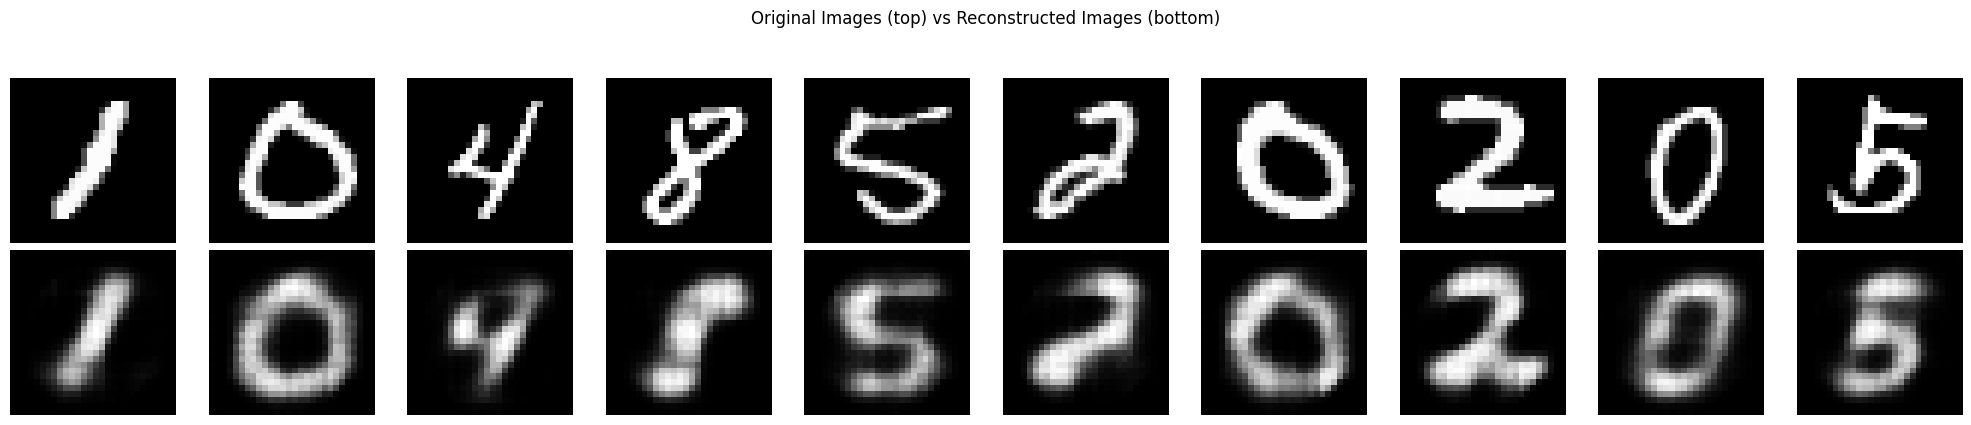

In [86]:
visualize_reconstructions(model, train_dataset)

In [35]:
# After training is complete
model.save("mnist_prototype_model.h5")

In [39]:
def visualize_weight_matrix(model):
    # Get the weights from the classifier layer (prototype to class weights)
    weights = model.classifier.get_weights()[0]  # Shape: [n_prototypes, n_classes]

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))

    # Display the weight matrix
    im = ax.imshow(weights, cmap='RdBu_r')

    # Set labels
    class_names = [str(i) for i in range(10)]  # MNIST digits 0-9

    # Add colorbar
    plt.colorbar(im)

    # Configure axes
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_xlabel('Digit Classes')
    ax.set_ylabel('Prototypes')

    # Add numbers in cells
    for i in range(weights.shape[0]):
        for j in range(weights.shape[1]):
            text = ax.text(j, i, f'{weights[i, j]:.2f}',
                         ha="center", va="center",
                         color="black" if abs(weights[i, j]) < 10 else "white")

    plt.title("Prototype-to-Class Weight Matrix")
    plt.tight_layout()
    plt.show()

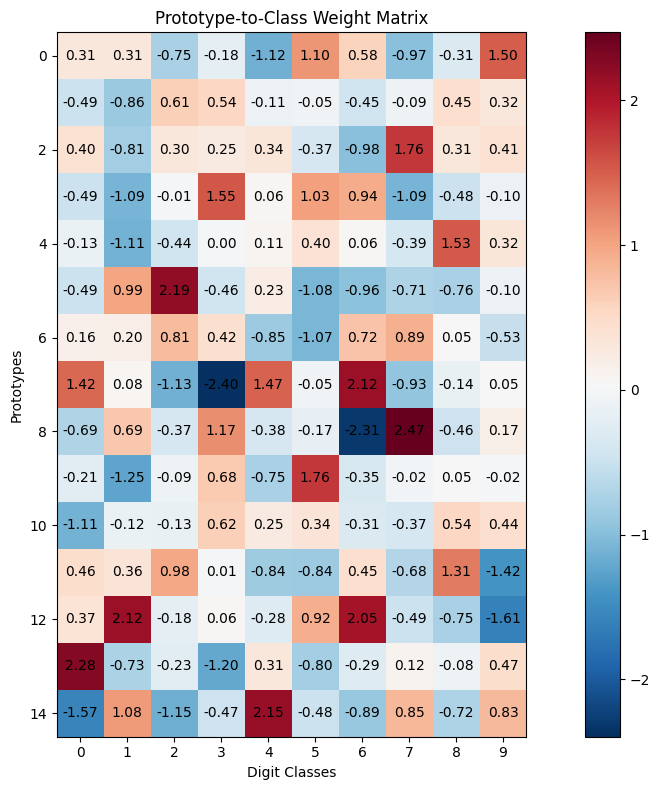

In [ ]:
# After training the model
visualize_weight_matrix(model)

In [41]:
def visualize_image_class_weights(model, dataset):
    # Get one sample image from each class
    images_by_class = [[] for _ in range(10)]
    for x_batch, y_batch in dataset:
        y_labels = tf.argmax(y_batch, axis=1)
        for img, label in zip(x_batch, y_labels):
            images_by_class[label.numpy()].append(img)
        if all(len(c) > 0 for c in images_by_class):
            break

    # Select first image from each class
    sample_images = [class_images[0] for class_images in images_by_class]
    sample_images = tf.stack(sample_images)

    # Get logits through the model
    logits, _, features, _ = model(sample_images)

    # Create figure with proper sizing
    fig = plt.figure(figsize=(15, 10))
    gs = plt.GridSpec(2, 1, height_ratios=[4, 1])

    # Plot weight matrix
    ax_weights = fig.add_subplot(gs[0])
    im = ax_weights.imshow(logits.numpy(), cmap='RdBu_r')
    plt.colorbar(im)

    # Add weight values in cells
    for i in range(logits.shape[0]):
        for j in range(logits.shape[1]):
            text_color = 'white' if abs(logits[i, j]) > 10 else 'black'
            ax_weights.text(j, i, f'{logits[i, j]:.2f}',
                          ha='center', va='center', color=text_color)

    # Plot sample digits on right side
    ax_images = fig.add_subplot(gs[1])
    for i in range(10):
        ax_images.imshow(sample_images[i],
                        extent=[i-0.5, i+0.5, 0, 1],
                        cmap='gray')

    # Configure axes
    ax_weights.set_xticks(range(10))
    ax_weights.set_xticklabels(range(10))
    ax_weights.set_ylabel('Input Images')
    ax_weights.set_xlabel('Digit Classes')
    ax_images.set_xticks([])
    ax_images.set_yticks([])

    plt.suptitle('Image-to-Class Weight Matrix')
    plt.tight_layout()
    plt.show()

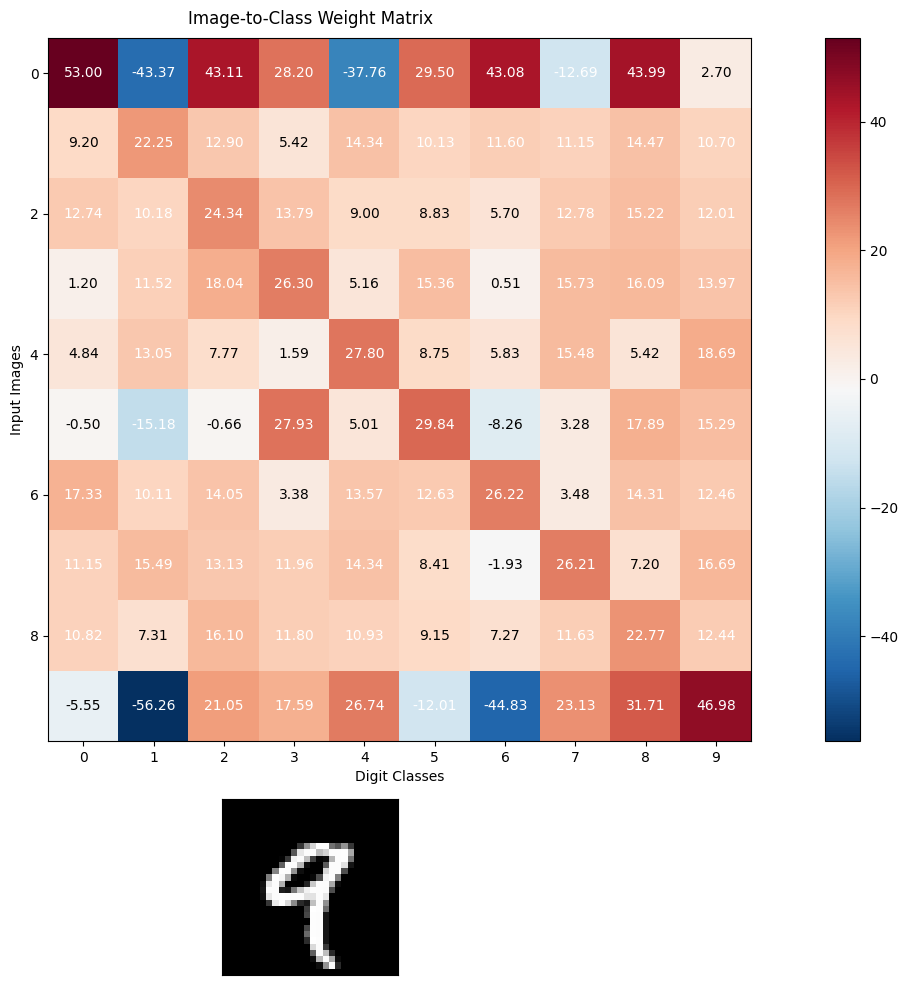

In [ ]:
visualize_image_class_weights(model, train_dataset)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 4, 4, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 4, 4, 10)       │         2,890 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 160)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,706 (84.79 KB)

 Trainable params: 21,706 (84.79 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 160)            │        25,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 4, 4, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_16             │ (None, 6, 6, 32)       │         2,912 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_17             │ (None, 12, 12, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_18             │ (None, 14, 14, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_19             │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,457 (185.38 KB)

 Trainable params: 47,457 (185.38 KB)

 Non-trainable params: 0 (0.00 B)

None


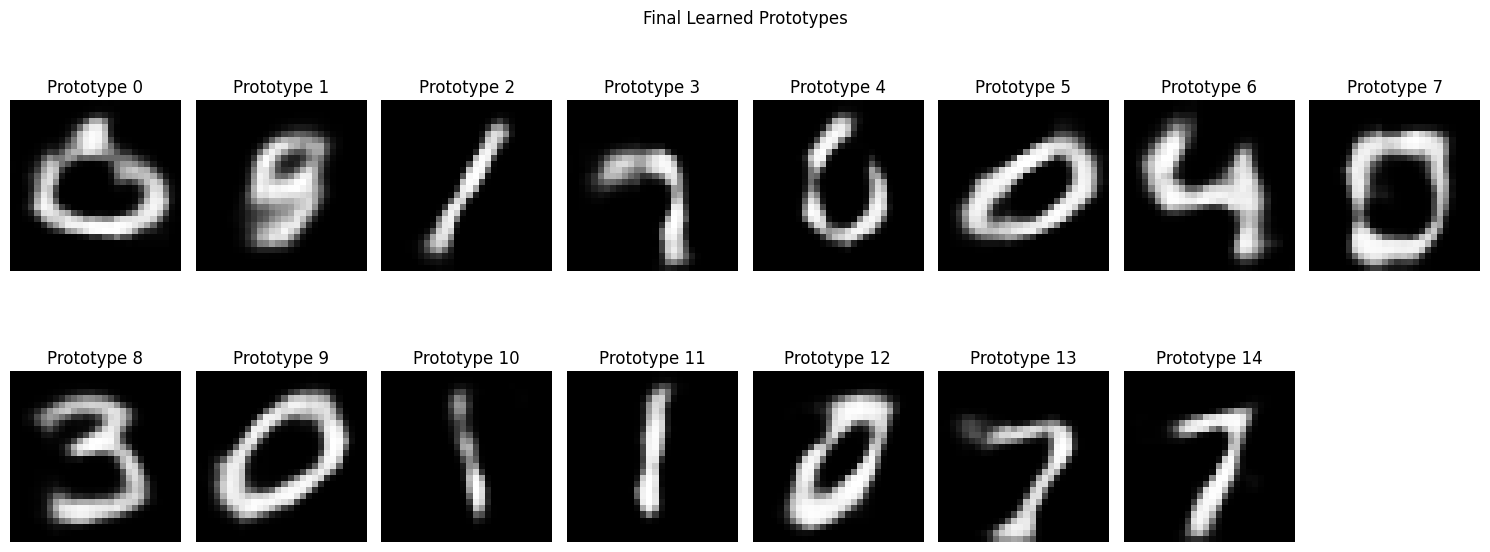

In [36]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def load_trained_model(model_path):
    """
    Load the trained prototype autoencoder model
    """
    model = PrototypeAutoencoder(input_shape=(28, 28, 1), n_classes=10, n_prototypes=15)

    # Create a dummy input to build the model
    dummy_input = tf.zeros((1, 28, 28, 1))
    model(dummy_input)

    # Load weights
    model.load_weights(model_path)
    return model

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_final_prototypes(model):
    """
    Visualize the final learned prototypes in image space
    """
    # Decode prototype vectors to image space
    prototypes = model.prototype_vectors.numpy()

    # Decode prototypes
    decoded_prototypes = model.decoder(prototypes).numpy()

    # Reshape to 28x28 images
    decoded_prototypes = decoded_prototypes.reshape(-1, 28, 28)

    # Plot decoded prototypes
    plt.figure(figsize=(15, 6))
    for i in range(len(decoded_prototypes)):
        plt.subplot(2, 8, i + 1)
        plt.imshow(decoded_prototypes[i], cmap='gray')
        plt.title(f'Prototype {i}')
        plt.axis('off')

    plt.tight_layout()
    plt.suptitle('Final Learned Prototypes', y=1.02)
    plt.show()

def visualize_prototype_activations(model, test_dataset):
    """
    Visualize prototype activations for individual images
    """
    # Iterate through test dataset
    for x_batch, y_batch in test_dataset.take(1):
        # Get model outputs
        logits, _, features, prototype_distances = model(x_batch)

        # Number of images to visualize
        num_images = min(5, x_batch.shape[0])

        # Create a large figure
        plt.figure(figsize=(20, 4 * num_images))

        for i in range(num_images):
            # Original image
            plt.subplot(num_images, 16, i * 16 + 1)
            plt.imshow(x_batch[i].numpy().squeeze(), cmap='gray')
            plt.title('Original')
            plt.axis('off')

            # Prototype distances for this image
            image_prototype_distances = prototype_distances[i].numpy()

            # Compute activations (lower distance means higher activation)
            activations = -image_prototype_distances

            # Normalize activations
            activations = (activations - activations.min()) / (activations.max() - activations.min())

            # Visualize each prototype's activation
            for p in range(len(activations)):
                plt.subplot(num_images, 16, i * 16 + p + 2)

                # Get the prototype
                prototype = model.prototype_vectors[p].numpy().reshape(4, 4, 10)

                # Visualize the first channel of the prototype
                plt.imshow(prototype[:,:,0], cmap='viridis', alpha=0.7)
                plt.title(f'P{p}\n{activations[p]:.2f}')
                plt.axis('off')

        plt.tight_layout()
        plt.suptitle('Prototype Activations for Test Images', y=1.02)
        plt.show()

# Load the trained model
model = load_trained_model("mnist_prototype_model.h5")

# Visualize final prototypes
visualize_final_prototypes(model)

# Visualize prototype activations
# visualize_prototype_activations(model, test_dataset)


Classification Accuracy: 93.10%


2024-12-10 12:40:57.119982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


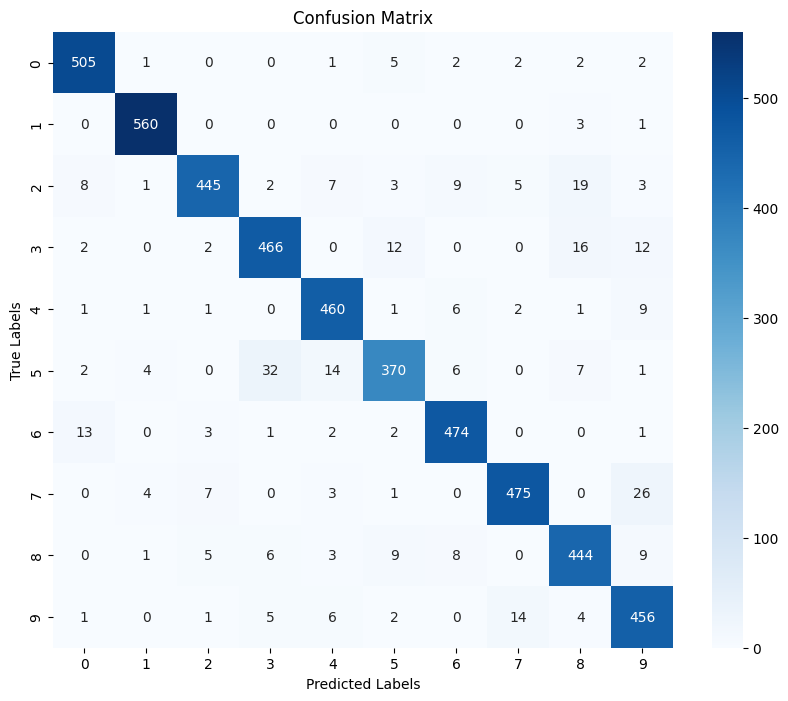


Detailed Classification Report:
              precision    recall  f1-score   support

     Class 0       0.95      0.97      0.96       520
     Class 1       0.98      0.99      0.99       564
     Class 2       0.96      0.89      0.92       502
     Class 3       0.91      0.91      0.91       510
     Class 4       0.93      0.95      0.94       482
     Class 5       0.91      0.85      0.88       436
     Class 6       0.94      0.96      0.95       496
     Class 7       0.95      0.92      0.94       516
     Class 8       0.90      0.92      0.91       485
     Class 9       0.88      0.93      0.90       489

    accuracy                           0.93      5000
   macro avg       0.93      0.93      0.93      5000
weighted avg       0.93      0.93      0.93      5000



In [38]:
def evaluate_classification_accuracy_prototype(model, test_dataset):
    """
    Evaluate classification accuracy of the prototype-based model.

    Args:
    - model: Trained prototype-based model.
    - test_dataset: Test dataset.

    Returns:
    - Accuracy
    - Confusion Matrix
    - True and Predicted Labels
    """
    # Collect true labels and predicted labels
    true_labels = []
    predicted_labels = []

    # Iterate through the test dataset
    for batch in test_dataset:
        # Unpack images and labels
        images, labels = batch

        # Ensure images are in the right shape
        if len(images.shape) == 3:
            images = tf.expand_dims(images, axis=-1)

        # Forward pass through the model
        logits, *_ = model(images)  # Get logits directly

        # Predict class with the highest logit
        predictions = tf.argmax(logits, axis=1)

        # If labels are one-hot encoded, convert to class indices
        if len(labels.shape) > 1:
            labels = tf.argmax(labels, axis=1)

        # Extend the lists
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predictions.numpy())

    # Convert to numpy arrays
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Calculate accuracy
    accuracy = np.mean(true_labels == predicted_labels)

    # Compute confusion matrix
    confusion_matrix = tf.math.confusion_matrix(
        labels=true_labels,
        predictions=predicted_labels,
        num_classes=10  # Assuming 10 classes (e.g., MNIST)
    ).numpy()

    return accuracy, confusion_matrix, true_labels, predicted_labels
# Evaluate the prototype model
accuracy, conf_matrix, true_labels, predicted_labels = evaluate_classification_accuracy_prototype(model, test_dataset)

# Print results
print(f"Classification Accuracy: {accuracy * 100:.2f}%")

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Generate and print classification report
from sklearn.metrics import classification_report
report = classification_report(true_labels, predicted_labels, target_names=[f'Class {i}' for i in range(10)])
print("\nDetailed Classification Report:")
print(report)
